In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem
from scipy.fftpack import fft
from scipy import signal
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [6]:
%matplotlib notebook

In [38]:
# Read in Electropherogram, headers should be "Time" and "RFU"
in_file = 'Example_Electropherogram.xlsx'
df = pd.read_excel(in_file,header=0)
df.head()

,Time,RFU
0,0.000,0.012884
1,0.125,0.013135
2,0.250,0.012960
3,0.375,0.012948
4,0.500,0.012943


In [52]:
TYPE='butter' # The Digital Filter to use, "butter" or "savgol". Check scipy documentation for more info on these filters.

#Butter Filter Settings
CUTOFF = 1 # Cut off frequency for the digital filter
ORDER = 2 # The digital filter order (will be 2x this since we apply the filter twice)
FS = 8 # The sampling rate in Hertz the input RFU values are recorded at

#Sav-gol filter settings
WINDOW = 25 # Length of the filter window (# of Coefficients)
POLY = 3 # Polynomial order for the filter


#General Filter call
def filter_data(data):
    """Put whatever filter you want to use here, should return the filtered data as ndarray
    
    :param data: 1D array of RFU or signal Values 
    :return: 1D array of filtered RFU data
    """
    
    if TYPE=='butter':
        return butter_lowpass_filter(data, CUTOFF, FS, ORDER)
    elif TYPE=='savgol':
        return savgol_filter(data)

# Filtering Functions
def butter_lowpass(cutoff, fs, order=5):
    "calculate the butter filter coefficients"
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    "Apply a butterworth digital filter"
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data, padlen=24, padtype='constant')
    return y    

def savgol_filter(data):
    "Apply Savinsky-golay digital filter"
    window_length = WINDOW # length of the filter window (number of coefficients)
    polyorder = POLY
    mode = 'constant'
    return signal.savgol_filter(data, window_length, polyorder, mode=mode)
    
def minimize_noise(data, time_points=40):
    """ Finds the minimal noise across the data for S/N calculations
    :param data: 1D array containing RFU values
    :param time_points: number of timepoints to gather the noise calculation over (time_points/sampling_freq = time)
    :return: noise start index, noise stop index, and the standard deviation of RFU between those indexes
    """
    max_noise = 10000
    skip_value=time_points
    max_indx = [120, 120+skip_value]
    for i in range(5,len(data)-skip_value):
        noise_st = i
        noise_end = noise_st+skip_value
        noise = np.std(data[noise_st:noise_end])
        if max_noise > noise and noise != 0:
            max_noise = noise
            max_indx = [noise_st,noise_end]
    noise = max_noise
    noise_st,noise_end=max_indx
    return noise_st, noise_end, noise


LOD is: 5.840898178097315e-21 moles


<IPython.core.display.Javascript object>


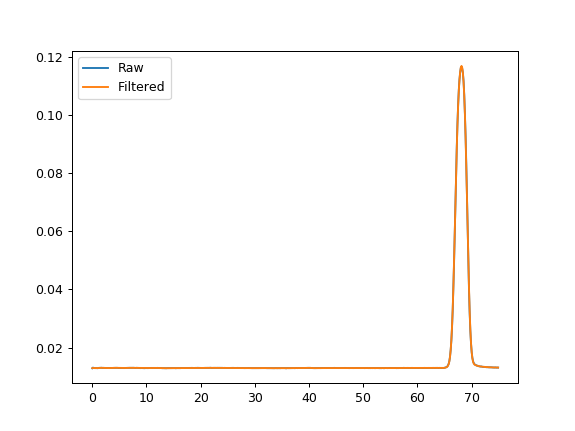

In [53]:

#Limit of Detection Values for mass limit of detection
injection_volume = 0.621*10**-9 # 0.621 nL
concentration = 40*10**-9 # 40 nM 

# Filter Data
filt_data = filter_data(data)


#Calculate SNR values
noise_st, noise_end, noise = minimize_noise(filt_data)
avg_noise = np.mean(filt_data[noise_st:noise_end])
max_signal = np.max(filt_data) - avg_noise

#Calculate LOD
moles_lod = noise*3/(max_signal)*(concentration)*injection_volume
print(f"LOD is: {moles_lod} moles")

# Plot the Raw and Filtered Electropherogram to inspect Ringing
plt.figure()
plt.plot(df.Time, df.RFU, label='Raw')
plt.plot(df.Time, filt_data, label='Filtered')
plt.legend()
plt.show()



D:\Software\MiniConda\envs\Dataworkup\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  import sys


<IPython.core.display.Javascript object>


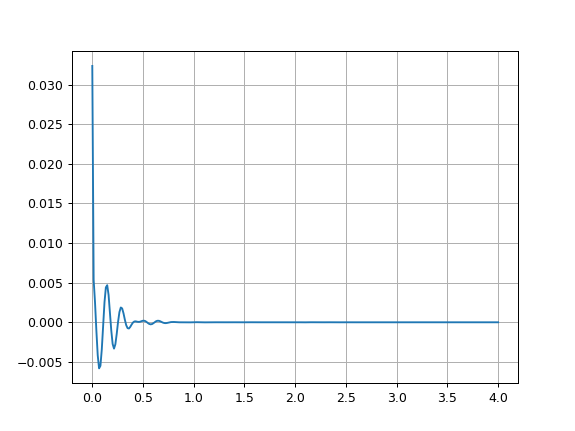

In [49]:
# FFT of Electropherogram To show Frequency components
# You can use this to help determine when to apply the cutoff for the digital fitler
data = df.RFU.values
T = 0.125 # sample spacing
yf = fft(data)
N=len(data)
xf = np.linspace(0,1/(2*T),N/2)

#Plot
fig, ax = plt.subplots(1)
plt.plot(xf, 2/N*yf[0:int(N/2)])
plt.grid()
plt.show()